# Apartment Image Extraction Application

<hr>

### Parameters

In [81]:
### DEBUG
marker_model_path = '/lab/data/celldom/model/r0.2/marker_model/marker_model.h5'
chip_config_path = '/lab/repos/celldom/config/chip_01_config.json'
dataset_path = '/lab/data/celldom/dataset/dataset03'
use_chip_scaling = False

In [11]:
# Parameters
marker_model_path = None
chip_config_path = None
dataset_path = None

# Defaults
use_chip_scaling = False

In [2]:
assert marker_model_path
assert chip_config_path
assert dataset_path

<hr>

## Initialization

In [3]:
%matplotlib inline
import os
import os.path as osp
import json
import tempfile
import celldom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from celldom.config import marker_config
from celldom.dataset import marker_dataset
from mrcnn import model as mrcnn_model_lib
from mrcnn import visualize as mrcnn_viz
from cvutils.mrcnn.session import init_keras_session
from celldom.warnings import disable_mrcnn_warnings
from celldom.preprocessing import marker_extraction
from celldom.preprocessing import apartment_extraction
from cvutils.mrcnn import model as mrcnn_model
from skimage import draw
from celldom import seed

pd.set_option('display.max_colwidth', 1000)
init_keras_session()
disable_mrcnn_warnings()
plt.gray()

tmp_model_dir = tempfile.gettempdir()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

#### Configuration Intitialization

In [4]:
with open(chip_config_path, 'r') as fd:
    chip_config = json.load(fd)
    
print('Loaded chip configuration:\n', json.dumps(chip_config, indent=4))

Loaded chip configuration:
 {
    "apt_num_margins": {
        "bottom": -170,
        "right": 75,
        "top": 210,
        "left": 0
    },
    "apt_margins": {
        "bottom": 60,
        "right": 75,
        "top": 250,
        "left": 160
    },
    "name": "Chip 1",
    "target_scale_factor": 200
}


In [5]:
inference_config = marker_config.MarkerInferenceConfig()
print('Loaded inference configuration:')
inference_config.display()

Loaded inference configuration:

Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EXPECTED_CLASS_COUNTS          {'Marker': 1}
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1408
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1408 1408    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_

#### Model Intitialization

In [6]:
print('Initializing marker detection model')
model = mrcnn_model.get_model('inference', inference_config, tmp_model_dir, init_with='file', file=marker_model_path)
print('Marker detection model initialization complete')

Initializing marker detection model
Marker detection model initialization complete


#### Dataset Intitialization

In [67]:
import glob
def get_data_files(path, pattern='*MOLM13*/*.tif'):
    files = glob.glob(osp.join(path, pattern))
    res = []
    for f in files:
        folder = osp.dirname(f).split(osp.sep)[-1]
        date, cells, cohort, conc, chip = folder.split()
        filename = osp.basename(f)
        address = '_'.join(filename.split('_')[:5])
        z = '_'.join(filename.split('_')[5:]).split('.')[0]
        res.append(dict(
            path=f, folder=folder, filename=filename, 
            date=date, cells=cells, cohort=cohort, 
            conc=conc, chip=chip, address=address, z=z
        ))
    return pd.DataFrame(res).sort_values('path')

In [68]:
data_files = get_data_files(dataset_path)
data_files.head()

,address,cells,chip,cohort,conc,date,filename,folder,path,z
6,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,2018.05.31.1610,BF_ST_000_APT_000_z_0.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_z_0.tif,z_0
0,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,2018.05.31.1610,BF_ST_000_APT_000_zm3.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm3.tif,zm3
1,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,2018.05.31.1610,BF_ST_000_APT_000_zm6.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm6.tif,zm6
2,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,2018.05.31.1610,BF_ST_000_APT_000_zm9.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zm9.tif,zm9
3,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,2018.05.31.1610,BF_ST_000_APT_000_zp3.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_000_APT_000_zp3.tif,zp3


In [69]:
data_files = data_files.sample(n=500, random_state=seed)

In [70]:
#!find $dataset_path | head

In [71]:
dataset = marker_dataset.MarkerDataset()
dataset.initialize(data_files['path'].values)
dataset.prepare()

<hr>

## Extraction

In [72]:
def run_extraction(image, detections):
    
    ##################
    ## Extract Markers
    ##################
    
    # All RGB image channels should be equivalent before proceeding
    if not np.all(image[..., 0] == image[..., 1]):
        raise ValueError('Expecting greyscale RGB images with equal channels')
        
    # Use bounding box predictions to establish points as marker centers
    centers = marker_extraction.get_marker_centers(image[..., 0], detections['rois'])
    
    # Determine marker neighbors based on an angular offset threshold and proximity
    neighbors = marker_extraction.get_marker_neighbors(centers.values, angle_range=(-25, 25))
    
    ########################
    ## Apply Transformations
    ########################
    
    # Infer the overall rotation and scale of the image as the median of those same 
    # quantities determined for each adjacent marker pair
    rotation, scale = neighbors['angle'].median(), neighbors['distance'].median()
    
    # Apply the inferred transformations to the raw image (and marker locations since
    # they will be used as the basis for extracting necessary patches)
    scale_factor = None
    if use_chip_scaling:
        scale_factor = chip_config['target_scale_factor'] / scale    

    norm_image, norm_centers = apartment_extraction.apply_normalization(image, centers, rotation=rotation, scale=scale_factor)
    
    ################################
    ## Extract Around Marker Offsets
    ################################
    
    apt_images = apartment_extraction.extract_images(norm_image, norm_centers, chip_config)
    
    return apt_images, norm_image, norm_centers, neighbors, rotation, scale

In [84]:
import tqdm

def run_extractions(model, dataset, data_files, return_images=False, image_ids=None):
    
    if image_ids is None:
        image_ids = dataset.image_ids
    n_ids = len(image_ids)
    
    extraction_summary = []
    for i, image_id in enumerate(image_ids):
        if i % max(len(image_ids) // 10, 1) == 0:
            print('Processing image {} of {} ({:.2f}%)'.format(i+1, n_ids, 100*(i+1)/n_ids))
            
        metadata = data_files.iloc[image_id].to_dict()
        image = dataset.load_image(image_id)

        detections = model.detect([image])[0]
        apt_images, norm_image, norm_centers, neighbors, rotation, scale = run_extraction(image, detections)

        record = dict(metadata)
        record['image_id'] = image_id
        record['scale'] = scale
        record['scales'] = neighbors['distance']
        record['rotation'] = rotation
        record['rotations'] = neighbors['angle']
        record['num_apartments'] = len(apt_images)
        record['num_markers'] = len(norm_centers)
        
        if save_images:
            record['normalized_image'] = norm_image[..., 0]
            record['raw_image'] = image[..., 0]
        extraction_summary.append(record)

    return pd.DataFrame(extraction_summary)

In [ ]:
extraction_summary = run_extractions(model, dataset, data_files)

<hr>

## Extraction Summary Analysis

In [74]:
extraction_summary[['scale', 'rotation']].describe()

,scale,rotation
count,500.000000,500.000000
mean,254.183563,0.427878
std,0.268711,0.336521
min,253.238944,-0.227098
25%,254.083837,0.096168
50%,254.170666,0.460618
75%,254.243283,0.681793
max,255.381647,1.012949


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47e935d7f0>],
      dtype=object)

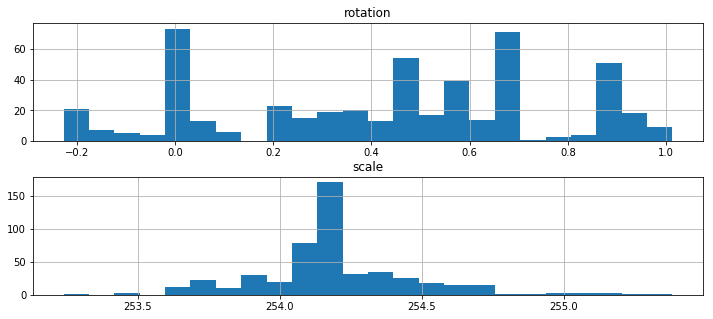

In [76]:
extraction_summary[['scale', 'rotation']].hist(layout=(2, 1), figsize=(12, 5), bins=24)

In [87]:
pd.set_option('display.max_colwidth', 1000)
primary_cols = ['address', 'date', 'num_apartments', 'num_markers', 'rotation', 'scale', 'path']
extraction_summary[primary_cols].sort_values('rotation', ascending=False).head()

,address,date,num_apartments,num_markers,rotation,scale,path
62,BF_ST_009_APT_000,2018.06.01.1710,9,16,1.012949,254.219577,/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_009_APT_000_zp3.tif
203,BF_ST_012_APT_008,2018.06.01.1710,9,16,1.011664,253.705019,/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_012_APT_008_zm6.tif
324,BF_ST_006_APT_012,2018.06.01.1710,9,16,1.008957,254.183432,/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_006_APT_012_zm9.tif
159,BF_ST_030_APT_044,2018.06.01.1710,4,7,1.008476,254.430297,/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_030_APT_044_zm9.tif
221,BF_ST_012_APT_020,2018.06.01.1710,9,16,1.004022,254.224541,/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_012_APT_020_zp3.tif


In [88]:
extraction_summary.loc[62]['path']

'/lab/data/celldom/dataset/dataset03/2018.06.01.1710 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_009_APT_000_zp3.tif'

Processing image 1 of 1 (100.00%)


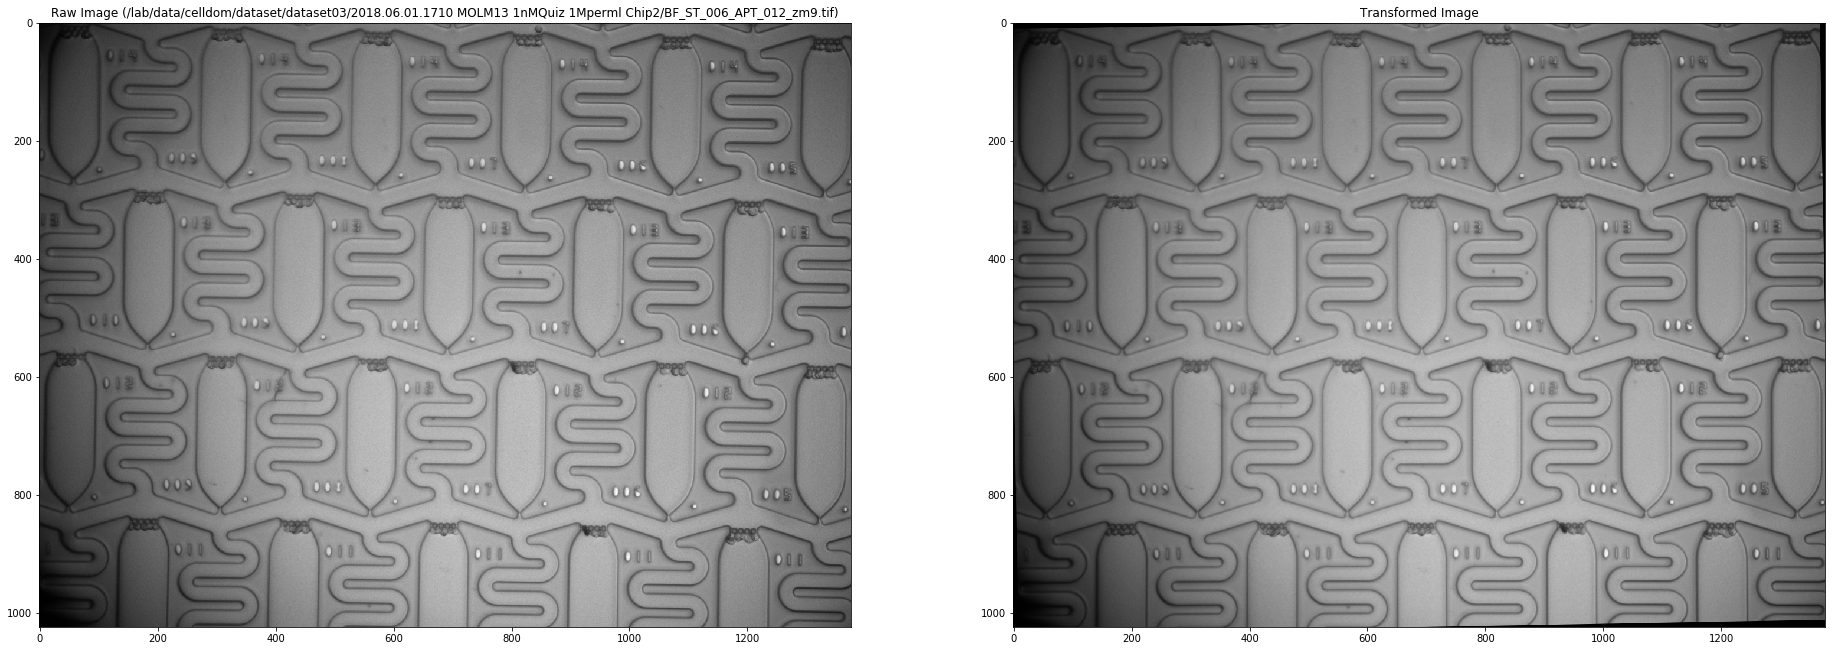

In [94]:
image_id = 324

df = run_extractions(model, dataset, data_files, return_images=True, image_ids=[image_id])
assert len(df) == 1
row = df.iloc[0]

fig, ax = plt.subplots(1, 2)
ax = ax.ravel()
ax[0].imshow(row['raw_image'])
ax[0].set_title('Raw Image ({})'.format(row['path']))
ax[1].imshow(row['normalized_image'])
ax[1].set_title('Transformed Image')
plt.gcf().set_size_inches(32, 16)

In [90]:
# image_id = 30
# fig, ax = plt.subplots(2, 1)
# ax = ax.ravel()
# ax[0].imshow(extraction_summary.loc[image_id]['raw_image'])
# ax[1].imshow(extraction_summary.loc[image_id]['normalized_image'])
# plt.gcf().set_size_inches(16, 16)

In [91]:
# import skimage
# plt.imshow(skimage.io.imread('/lab/data/celldom/dataset/dataset03/2018.06.01.2307 MOLM13 NoDrug 1Mperml Chip2/BF_ST_015_APT_038_zp3.tif'))
# #plt.imshow(skimage.io.imread('/lab/data/celldom/dataset/dataset03/2018.06.02.1800 MOLM13 1nMQuiz 1Mperml Chip2/BF_ST_000_APT_034_zm9.tif'))
# plt.gcf().set_size_inches(16, 8)